In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
tf.keras.backend.set_floatx('float64')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
df = pd.read_csv('./Data/Z1P-AX.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3.56,3.61,3.515,3.54,3.54,1277630
2020-01-03,3.59,3.62,3.520,3.53,3.53,2240109
2020-01-06,3.52,3.52,3.430,3.45,3.45,3995587
2020-01-07,3.48,3.51,3.405,3.42,3.42,2263956
2020-01-08,3.40,3.40,3.160,3.18,3.18,5693994


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-01-02 to 2020-12-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [6]:
truth = df['Close']
prediction = df['Close'].shift()
prediction = prediction.fillna(method='backfill')
mse = mean_squared_error(truth, prediction)
print(mse)

0.09438492063492065


In [7]:
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

In [8]:
look_back = 7
train_size = int(0.6 * len(data))
valid_size = int(0.2 * len(data))

x_train, y_train = [], []
for i in range(look_back, train_size + valid_size):
    x_train.append(data[i - look_back : i])
    y_train.append(data[i])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train, x_valid = x_train[:train_size], x_train[train_size:]
y_train, y_valid = y_train[:train_size], y_train[train_size:]

In [9]:
print(x_train.shape)
print(x_valid.shape)

(151, 7, 1)
(43, 7, 1)


In [10]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=10, 
    batch_size=len(x_train), 
    validation_data=(x_valid, y_valid),
    shuffle=False
)

Train on 151 samples, validate on 43 samples
Epoch 1/10
151/151 [==============================] - 5s 32ms/sample - loss: 0.1483 - val_loss: 0.4061
Epoch 2/10
151/151 [==============================] - 0s 327us/sample - loss: 0.1308 - val_loss: 0.3613
Epoch 3/10
151/151 [==============================] - 0s 351us/sample - loss: 0.1142 - val_loss: 0.3179
Epoch 4/10
151/151 [==============================] - 0s 287us/sample - loss: 0.0984 - val_loss: 0.2757
Epoch 5/10
151/151 [==============================] - 0s 358us/sample - loss: 0.0834 - val_loss: 0.2347
Epoch 6/10
151/151 [==============================] - 0s 322us/sample - loss: 0.0690 - val_loss: 0.1948
Epoch 7/10
151/151 [==============================] - 0s 421us/sample - loss: 0.0556 - val_loss: 0.1564
Epoch 8/10
151/151 [==============================] - 0s 289us/sample - loss: 0.0431 - val_loss: 0.1200
Epoch 9/10
151/151 [==============================] - 0s 282us/sample - loss: 0.0319 - val_loss: 0.0867
Epoch 10/10
151/151 

In [12]:
x_test, y_test = [], []
for i in range(train_size + valid_size, len(data)):
    x_test.append(data[i - look_back : i])
    y_test.append(data[i])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
model.evaluate(x_test, y_test)

51/51 [==============================] - 0s 273us/sample - loss: 0.0197


0.019723780361898972

In [13]:
train_date = df.index[look_back:train_size + look_back]
valid_date = df.index[train_size + look_back: train_size + valid_size]
test_date = df.index[train_size + valid_size:]

train_pred = scaler.inverse_transform(model(x_train))
valid_pred = scaler.inverse_transform(model(x_valid))
test_pred = scaler.inverse_transform(model(x_test))

In [15]:
look_ahead = 10
future_date = pd.date_range(start=df.index[-1], periods=look_ahead+1)[1:]
future_date

DatetimeIndex(['2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01',
               '2021-01-02', '2021-01-03'],
              dtype='datetime64[ns]', freq='D')

In [17]:
future_pred = []
past = data[-look_back:].reshape((1, look_back, 1))
for _ in range(look_ahead):
    pred = model(past).numpy()
    future_pred.append(pred)
    past = np.concatenate([past, np.array([pred]).reshape((1, 1, 1))], axis=1)
    past = past[:, -look_back:]
future_pred = np.array(future_pred).reshape((1, -1))
future_pred = scaler.inverse_transform(future_pred)
future_pred = future_pred.reshape(-1)
future_pred

array([4.39094851, 4.33343502, 4.24949845, 4.1654096 , 4.09106208,
       4.0100864 , 3.91788754, 3.80789155, 3.7680002 , 3.72629276])

In [18]:
pd.DataFrame(future_pred, columns=['Close'], index=future_date)

,Close
2020-12-25,4.390949
2020-12-26,4.333435
2020-12-27,4.249498
2020-12-28,4.165410
2020-12-29,4.091062
2020-12-30,4.010086
2020-12-31,3.917888
2021-01-01,3.807892
2021-01-02,3.768000
2021-01-03,3.726293


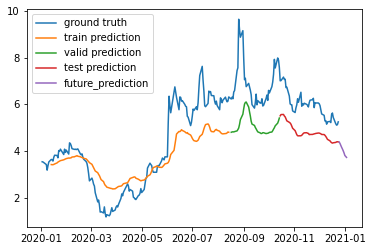

In [19]:
fig = plt.figure()
plt.plot(df.index, df['Close'], label='ground truth')
plt.plot(train_date, train_pred, label='train prediction')
plt.plot(valid_date, valid_pred, label='valid prediction')
plt.plot(test_date, test_pred, label='test prediction')
plt.plot(future_date, future_pred, label='future_prediction')
plt.legend()
plt.show()